In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, linear_model
import pickle
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pystan
import pystan_utils
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)
import time
import random
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os
import seaborn as sns
import sklearn
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score

pd.options.display.max_rows=200
pd.options.display.max_columns=999

plt.rcParams['figure.figsize'] = (15, 7)
colore="#6699cc" 
stile_linea='-.'
import warnings; warnings.simplefilter('ignore')

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Datasets:
# Alighting 
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Alighting_2017_w", 'rb')
al = pickle.load(f1)
f1.close()

# Boarding
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Boarding_2017_w", 'rb')
bo = pickle.load(f1)
f1.close()

# Dwell time dataset
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Dwell_2017_w", 'rb')
dw = pickle.load(f1)
f1.close()

# Events
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\events\\READY\\Event_with_topics_label", 'rb')
ev = pickle.load(f1)
f1.close()


ev['starting_time']=pd.to_datetime(ev['starting_time'],format="%Y-%m-%d %H:%M:%S")
ev['end_time']=pd.to_datetime(ev['end_time'],format="%Y-%m-%d %H:%M:%S")


ev['venue_unique']=ev['venue_unique'].replace("ForumCopenhagen", "Forum")
ev['venue_unique']=ev['venue_unique'].replace("DrKoncerthuset", "DR Koncerthuset")
ev['venue_unique']=ev['venue_unique'].replace("RoyalArena", "Royal Arena")
ev['venue_unique']=ev['venue_unique'].replace("BellaCenter", "Bella Center")
ev['venue_unique']=ev['venue_unique'].replace("TeliaParken", "Parken")


al=al[al['AlightingPassengerCount']>0]
bo=bo[bo['BoardingPassengerCount']>0]
dw=dw[dw['DwellSeconds']<90]

In [6]:
al.AlightingPassengerCount.std()
bo.BoardingPassengerCount.std()
dw.DwellSeconds.std()

13.239282649583668

In [16]:
color_scatter=[]
for i in range(20):
    r1=random.uniform(0, 1)
    r2=random.uniform(0, 1)
    r3=random.uniform(0, 1)
    color_scatter.append([r1,r2,r3])

In [8]:
def h_after_start(df):
    df['event_during_1h_aft']=((df['Time_difference']>=-1)&(df['Time_difference']<0)&(df['event_during']>0))*1
    df['event_during_2h_aft']=((df['Time_difference']>=-2)&(df['Time_difference']<-1)&(df['event_during']>0))*1
    df['event_during_3h_aft']=((df['Time_difference']>=-3)&(df['Time_difference']<-2)&(df['event_during']>0))*1
    df['event_during_4h_aft']=((df['Time_difference']>=-4)&(df['Time_difference']<-3)&(df['event_during']>0))*1
    df['event_during_5h_aft']=((df['Time_difference']>=-5)&(df['Time_difference']<-4)&(df['event_during']>0))*1
    df['event_during_6h_aft']=((df['Time_difference']>=-6)&(df['Time_difference']<-5)&(df['event_during']>0))*1
    for i in range(6):
        df["H%s_%s"%(i*4,(i*4)+4)]=0
        df["H%s_%s"%(i*4,(i*4)+4)][(df['hours']>=i*4) & (df['hours']<(i*4)+4)]=1
    df['Temperature']=[float(i) for i in df['Temperature']]
    df['Precipitation']=[float(i) for i in df['Precipitation']]
    
    df['Entertainment']=df['Entertainment']+df['entertainment']
    df=df.drop('entertainment', 1)
    df['Classic_Music']=df['Classic_Music']+df['Classical_Music']
    df=df.drop('Classical_Music', 1)
    df['Music']=df['Music']+df['Music.1']
    df=df.drop('Music.1', 1)
    df.rename(columns={'Fælledparken': 'Outdoor_Festival'}, inplace=True)
    
    
    
    return df

def set_size(width, fraction=1):
    # Width of figure
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) /1.5
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim

nice_fonts = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.titlesize": 9,
}

nice_fonts_small = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 6,
        "font.size": 6,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
}


#function to lag

def buildLaggedFeatures(s,columns, lag=336,dropna=True): #lag=3
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)
    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

def considered_stations(df):
    st_notConsidered=[50822,1547,28000	,900	,46743	,	1410,30941]
    station_considered=[678,  1586, 27999, 1365,   860 , 30941]
    list_df=[]
    for st in station_considered:
        dataf=df[df['StopPointId']==st]
        list_df.append(dataf)
    only_st_considered=pd.concat(list_df)
    try:
        only_st_considered=only_st_considered.sort_values(by='TimeStep')
    except:
        only_st_considered=only_st_considered.sort_values(by='ObservedArrivalDateTime')
    return only_st_considered

def considered_stations_dw(df):
    st_notConsidered=[50822,1547,46743	,	1410,28005,27548,46743, 30942,30941]
    station_considered=[678,  1586, 27999, 1365,   860 ]
    list_df=[]
    for st in station_considered:
        dataf=df[df['StopPointId']==st]
        list_df.append(dataf)
    only_st_considered=pd.concat(list_df)
    try:
        only_st_considered=only_st_considered.sort_values(by='TimeStep')
    except:
        only_st_considered=only_st_considered.sort_values(by='ObservedArrivalDateTime')
    return only_st_considered

def event_day(df):
    listone=[]
    dataf_ev=df[df['isEvent']>0]
    dataf_ev.TimeStep.dt.day[dataf_ev['TimeStep'].dt.month==1].unique()
    for mo in range(1,13):
        dataf_ev_mo=df[df['TimeStep'].dt.month==mo]
        for da in dataf_ev.TimeStep.dt.day[dataf_ev['TimeStep'].dt.month==mo].unique():
            dataf_ev_da=dataf_ev_mo[dataf_ev_mo['TimeStep'].dt.day==da]
            listone.append(dataf_ev_da)

    al_event_day=pd.concat(listone)
    return al_event_day

In [9]:
al=h_after_start(al)
bo=h_after_start(bo)
dw=h_after_start(dw)

al=considered_stations(al)
bo=considered_stations(bo)
dw=considered_stations_dw(dw)

dw["isStopping"]=(dw["DwellSeconds"]>0)*1
dw["isStopping_lag1"]=(dw["DwellSeconds_lag1"]>0)*1
dw["isStopping_lag2"]=(dw["DwellSeconds_lag2"]>0)*1
dw["isStopping_lag3"]=(dw["DwellSeconds_lag3"]>0)*1
dw["isStopping_lag4"]=(dw["DwellSeconds_lag4"]>0)*1
dw["isStopping_lag5"]=(dw["DwellSeconds_lag5"]>0)*1

In [10]:
dw['isEvent']= dw['event_1h_aft']+  dw['event_2h_aft']+ dw['event_3h_aft']+ dw['event_during']+ dw['event_1h_bef']+  dw['event_2h_bef']+ dw['event_3h_bef']
al['isEvent']=  al['event_1h_bef']+  al['event_2h_bef']+ al['event_3h_bef'] 
bo['isEvent']= bo['event_1h_aft']+  bo['event_2h_aft']+ bo['event_3h_aft'] + bo['event_during_5h_aft']+ bo['event_during_6h_aft']

In [137]:
for st in al.StopPointId.unique():
    print(st,"\t",al.PoiName[al['StopPointId']==st].unique()[0])

678 	 Forum
1586 	 Vega
27999 	 Bella Center
860 	 DR Koncerthuset
1365 	 Parken
30941 	 Royal Arena


In [138]:
for st in dw.StopPointId.unique():
    print(st,"\t",dw.PoiName[dw['StopPointId']==st].unique()[0])

1365 	 Parken
1586 	 Vega
678 	 Forum
27999 	 Bella Center
860 	 DR Koncerthuset


-----------------------------

# Demand ditribution

In [139]:
al['isEvent']=0
al['isEvent'][(al['Time_difference']<4)&(al['Time_difference']>-1)]=1

In [140]:
al_e=al[al['isEvent']>0]
al_n=al[al['isEvent']==0]

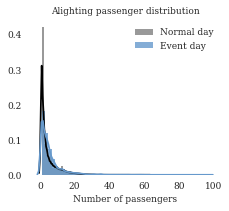

In [141]:
plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

# ax.hist(al.AlightingPassengerCount,color="k",bins=50);7
sns.distplot(al_n.AlightingPassengerCount,color="k",hist_kws={ "alpha": 0.4},label="Normal day")
sns.distplot(al_e.AlightingPassengerCount,color=colore,hist_kws={ "alpha": 0.8},label="Event day")

plt.xlabel("Number of passengers")

plt.title("Alighting passenger distribution")
plt.legend()


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/al_distribution.pdf", format='pdf', bbox_inches='tight')

In [142]:
for st in al.StopPointId.unique():
    print("\n",st)
    al_s=al[al['StopPointId']==st]
    
    print(len(al_s[al_s['isEvent']>0])/len(al_s))
    
    
    q98=al_s.AlightingPassengerCount.quantile(0.98)
    print("Quantile 98",q98)
    al_s98=al_s[al_s['AlightingPassengerCount']>=q98]
    print(len(al_s98[al_s98['isEvent']>0])/len(al_s98))
    
    
    q99=al_s.AlightingPassengerCount.quantile(0.99)
    print("Quantile 99",q99)
    al_s99=al_s[al_s['AlightingPassengerCount']>=q99]
    print(len(al_s99[al_s99['isEvent']>0])/len(al_s99))
    
    
    


 678
0.018476520811099253
Quantile 98 26.0
0.0377906976744186
Quantile 99 29.0
0.04395604395604396

 1586
0.1482432804329878
Quantile 98 10.0
0.5559440559440559
Quantile 99 13.0
0.5923076923076923

 27999
0.02794329155537292
Quantile 98 10.0
0.35096153846153844
Quantile 99 14.0
0.4803921568627451

 860
0.09255242227042661
Quantile 98 4.0
0.12389380530973451
Quantile 99 5.0
0.1111111111111111

 1365
0.08443942389155605
Quantile 98 15.0
0.7439024390243902
Quantile 99 20.59999999999991
0.8611111111111112

 30941
0.054732775273663874
Quantile 98 4.0
0.16666666666666666
Quantile 99 4.0
0.16666666666666666


In [143]:
for st in bo.StopPointId.unique():
#     print("\n",st)
    bo_s=bo[bo['StopPointId']==st]
    
    print(st,(len(bo_s)/len(bo)))
    
#     print(len(bo_s[bo_s['isEvent']>0])/len(bo_s))
    
    
#     q98=bo_s.BoardingPassengerCount.quantile(0.98)
#     print(q98)
#     bo_s98=bo_s[bo_s['BoardingPassengerCount']>=q98]
#     print(len(bo_s98[bo_s98['isEvent']>0])/len(bo_s98))
    
    
#     q99=bo_s.BoardingPassengerCount.quantile(0.99)
#     print(q99)
#     bo_s99=bo_s[bo_s['BoardingPassengerCount']>=q99]
#     print(len(bo_s99[bo_s99['isEvent']>0])/len(bo_s99))
    
    


678 0.488836891878717
1586 0.23574144486692014
1365 0.04822722693445127
27999 0.11120860550518345
860 0.06827857398199604
30941 0.047707256832732116


In [144]:
bo.BoardingPassengerCount.quantile(0.98)

25.0

In [145]:
for st in dw.StopPointId.unique():
    print("\n",st)
    dw_s=dw[dw['StopPointId']==st]
    
    print(len(dw_s[dw_s['isEvent']>0])/len(dw_s))
    
    
    q98=dw_s.DwellSeconds.quantile(0.98)
    print(q98)
    dw_s98=dw_s[dw_s['DwellSeconds']>=q98]
    print(len(dw_s98[dw_s98['isEvent']>0])/len(dw_s98))
    
    
    q99=dw_s.DwellSeconds.quantile(0.99)
    print(q99)
    dw_s99=dw_s[dw_s['DwellSeconds']>=q99]
    print(len(dw_s99[dw_s99['isEvent']>0])/len(dw_s99))
    
    
    

print(len(dw[dw['isEvent']>0])/len(dw))
q98=dw.DwellSeconds.quantile(0.98)
print(q98)
dw_s98=dw[dw['DwellSeconds']>=q98]
print(len(dw_s98[dw_s98['isEvent']>0])/len(dw_s98))
q99=dw_s.DwellSeconds.quantile(0.99)
print(q99)
dw_s99=dw[dw['DwellSeconds']>=q99]
print(len(dw_s99[dw_s99['isEvent']>0])/len(dw_s99))



 1365
0.05561021316467557
30.0
0.35023041474654376
37.0
0.484304932735426

 1586
0.17360172027754994
35.0
0.14864864864864866
40.0
0.13983050847457626

 678
0.053518522013172046
62.0
0.07096171802054155
71.0
0.08043875685557587

 27999
0.07685582247387485
34.0
0.17139090309822017
45.0
0.15653298835705046

 860
0.11468780329990294
32.0
0.1527001862197393
38.0
0.11507936507936507
0.0935485362808121
47.0
0.0965391621129326
38.0
0.10030225008395835


# dist boarding

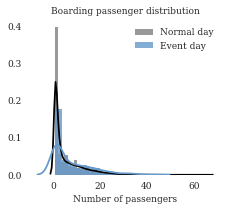

In [54]:
bo_e=bo[bo['isEvent']>0]
bo_n=bo[bo['isEvent']==0]
plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

# ax.hist(al.AlightingPassengerCount,color="k",bins=50);7
sns.distplot(bo.BoardingPassengerCount,color="k",hist_kws={ "alpha": 0.4},label="Normal day")
sns.distplot(bo_e.BoardingPassengerCount,color=colore,hist_kws={ "alpha": 0.8},label="Event day")

plt.xlabel("Number of passengers")

plt.title("Boarding passenger distribution")
plt.legend()


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/bo_distribution.pdf", format='pdf', bbox_inches='tight')

# Event impact Al

In [146]:
col_y=["AlightingPassengerCount"]
historical_average=[None] * len(al)
historical_average=np.array(historical_average)

historical_average[(al['day']==5)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)]=al[col_y][(al['day']==5)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)].mean()
historical_average[(al['day']==5)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)]=al[col_y][(al['day']==5)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)].mean()
historical_average[(al['day']==5)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)]=al[col_y][(al['day']==5)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)].mean()
historical_average[(al['day']==5)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)]=al[col_y][(al['day']==5)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)].mean()
historical_average[(al['day']==5)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)]=al[col_y][(al['day']==5)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)].mean()
historical_average[(al['day']==5)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)]=al[col_y][(al['day']==5)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)].mean()
#sunday
historical_average[(al['day']==6)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)]=al[col_y][(al['day']==6)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)].mean()
historical_average[(al['day']==6)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)]=al[col_y][(al['day']==6)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)].mean()
historical_average[(al['day']==6)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)]=al[col_y][(al['day']==6)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)].mean()
historical_average[(al['day']==6)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)]=al[col_y][(al['day']==6)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)].mean()
historical_average[(al['day']==6)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)]=al[col_y][(al['day']==6)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)].mean()
historical_average[(al['day']==6)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)]=al[col_y][(al['day']==6)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)].mean()
#weekday
historical_average[(al['day']<5)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)]=al[col_y][(al['day']<5)&(al['hours']>=0)&(al['isEvent']==0)&(al['hours']<4)].mean()
historical_average[(al['day']<5)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)]=al[col_y][(al['day']<5)&(al['hours']>=4)&(al['isEvent']==0)&(al['hours']<7)].mean()
historical_average[(al['day']<5)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)]=al[col_y][(al['day']<5)&(al['hours']>=7)&(al['isEvent']==0)&(al['hours']<9)].mean()
historical_average[(al['day']<5)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)]=al[col_y][(al['day']<5)&(al['hours']>=9)&(al['isEvent']==0)&(al['hours']<15)].mean()
historical_average[(al['day']<5)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)]=al[col_y][(al['day']<5)&(al['hours']>=15)&(al['isEvent']==0)&(al['hours']<18)].mean()
historical_average[(al['day']<5)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)]=al[col_y][(al['day']<5)&(al['hours']>=18)&(al['isEvent']==0)&(al['hours']<24)].mean()

#is event
historical_average[(al['day']==5)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)]=al[col_y][(al['day']==5)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)].mean()
historical_average[(al['day']==5)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)]=al[col_y][(al['day']==5)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)].mean()
historical_average[(al['day']==5)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)]=al[col_y][(al['day']==5)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)].mean()
historical_average[(al['day']==5)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)]=al[col_y][(al['day']==5)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)].mean()
historical_average[(al['day']==5)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)]=al[col_y][(al['day']==5)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)].mean()
historical_average[(al['day']==5)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)]=al[col_y][(al['day']==5)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)].mean()
#sunday
historical_average[(al['day']==6)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)]=al[col_y][(al['day']==6)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)].mean()
historical_average[(al['day']==6)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)]=al[col_y][(al['day']==6)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)].mean()
historical_average[(al['day']==6)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)]=al[col_y][(al['day']==6)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)].mean()
historical_average[(al['day']==6)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)]=al[col_y][(al['day']==6)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)].mean()
historical_average[(al['day']==6)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)]=al[col_y][(al['day']==6)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)].mean()
historical_average[(al['day']==6)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)]=al[col_y][(al['day']==6)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)].mean()
#weekday
historical_average[(al['day']<5)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)]=al[col_y][(al['day']<5)&(al['hours']>=0)&(al['isEvent']>0)&(al['hours']<4)].mean()
historical_average[(al['day']<5)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)]=al[col_y][(al['day']<5)&(al['hours']>=4)&(al['isEvent']>0)&(al['hours']<7)].mean()
historical_average[(al['day']<5)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)]=al[col_y][(al['day']<5)&(al['hours']>=7)&(al['isEvent']>0)&(al['hours']<9)].mean()
historical_average[(al['day']<5)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)]=al[col_y][(al['day']<5)&(al['hours']>=9)&(al['isEvent']>0)&(al['hours']<15)].mean()
historical_average[(al['day']<5)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)]=al[col_y][(al['day']<5)&(al['hours']>=15)&(al['isEvent']>0)&(al['hours']<18)].mean()
historical_average[(al['day']<5)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)]=al[col_y][(al['day']<5)&(al['hours']>=18)&(al['isEvent']>0)&(al['hours']<24)].mean()



In [147]:
al['Avg']=historical_average
al['real_minus_AVG']=al['AlightingPassengerCount']-al['Avg']
al['real_minus_AVG_rate']=al['real_minus_AVG']/al['Avg']
al['isEvent']=0
al['isEvent'][(al['Time_difference']<4)&(al['Time_difference']>-1)]=1



In [148]:
for st in al.StopPointId.unique():
    print("\n",st)
    al_st=al[al["StopPointId"]==st]
    print(len(al_st[(al_st['isEvent']>0)])/len(al_st))
    print(len(al_st[(al_st['real_minus_AVG_rate']>0.5)&(al_st['isEvent']>0)]),"\t",len(al_st[(al_st['real_minus_AVG_rate']>0.5)&(al_st['isEvent']>0)])/len(al_st[(al_st['real_minus_AVG_rate']>0.5)]))
    print(len(al_st[(al_st['real_minus_AVG_rate']>1)&(al_st['isEvent']>0)]),"\t",len(al_st[(al_st['real_minus_AVG_rate']>1)&(al_st['isEvent']>0)])/len(al_st[(al_st['real_minus_AVG_rate']>1)]))


 678
0.018476520811099253
143 	 0.016065610605549938
102 	 0.015882902522578637

 1586
0.1482432804329878
265 	 0.40458015267175573
119 	 0.468503937007874

 27999
0.02794329155537292
64 	 0.11721611721611722
49 	 0.17625899280575538

 860
0.09255242227042661
0 	 0.0
0 	 0.0

 1365
0.08443942389155605
111 	 0.6416184971098265
78 	 0.6724137931034483

 30941
0.054732775273663874
0 	 0.0
0 	 0.0


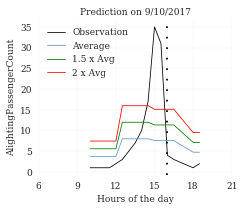

In [153]:
al_st=al[al["StopPointId"]==1365]


da=10
mo=9
ho=16

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

al_st_inde=al_st.reset_index()
indexs=al_st_inde.index[(al_st_inde['TimeStep'].dt.month==mo) & (al_st_inde['TimeStep'].dt.day==da)] 

plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
H_min=al_st_inde.iloc[indexs].hours+(al_st_inde.iloc[indexs].TimeStep.dt.minute)/60


plt.plot(H_min,al_st_inde.AlightingPassengerCount.iloc[indexs],c="k", label="Observation",linewidth=0.8)
plt.plot(H_min,al_st_inde.Avg.iloc[indexs],c=colore, label="Average",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*1.5),c="g", label="1.5 x Avg",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*2),c="r", label="2 x Avg",linewidth=0.8)

# plt.plot(H_min,y_test[0][indexs],c="k", label="True",linewidth=0.8)
# plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
# plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
# plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
# plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(loc=2)
plt.xticks(range(6,22,3))
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.title("Prediction on %s/%s/2017"%(mo,da))
plt.ylabel("%s"%(col_y[0]))
plt.xlabel("Hours of the day")


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/event_over_average_Parken_9_10.pdf", format='pdf', bbox_inches='tight')

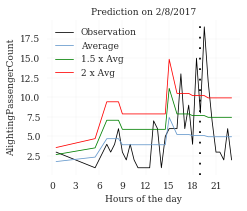

In [154]:
al_st=al[al["StopPointId"]==1586]


da=8
mo=2
ho=19

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

al_st_inde=al_st.reset_index()
indexs=al_st_inde.index[(al_st_inde['TimeStep'].dt.month==mo) & (al_st_inde['TimeStep'].dt.day==da)] 

plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
H_min=al_st_inde.iloc[indexs].hours+(al_st_inde.iloc[indexs].TimeStep.dt.minute)/60


plt.plot(H_min,al_st_inde.AlightingPassengerCount.iloc[indexs],c="k", label="Observation",linewidth=0.8)
plt.plot(H_min,al_st_inde.Avg.iloc[indexs],c=colore, label="Average",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*1.5),c="g", label="1.5 x Avg",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*2),c="r", label="2 x Avg",linewidth=0.8)

# plt.plot(H_min,y_test[0][indexs],c="k", label="True",linewidth=0.8)
# plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
# plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
# plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
# plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(loc=2)
plt.xticks(range(0,24,3))
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.title("Prediction on %s/%s/2017"%(mo,da))
plt.ylabel("%s"%(col_y[0]))
plt.xlabel("Hours of the day")


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/event_over_average_Vega_2_8.pdf", format='pdf', bbox_inches='tight')

# inpact of event bo

In [155]:
col_y=["BoardingPassengerCount"]
historical_average=[None] * len(bo)
historical_average=np.array(historical_average)

historical_average[(bo['day']==5)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)]=bo[col_y][(bo['day']==5)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)]=bo[col_y][(bo['day']==5)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)]=bo[col_y][(bo['day']==5)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)]=bo[col_y][(bo['day']==5)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)]=bo[col_y][(bo['day']==5)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)]=bo[col_y][(bo['day']==5)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)].mean()
#sunday
historical_average[(bo['day']==6)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)]=bo[col_y][(bo['day']==6)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)]=bo[col_y][(bo['day']==6)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)]=bo[col_y][(bo['day']==6)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)]=bo[col_y][(bo['day']==6)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)]=bo[col_y][(bo['day']==6)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)]=bo[col_y][(bo['day']==6)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)].mean()
#weekday
historical_average[(bo['day']<5)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)]=bo[col_y][(bo['day']<5)&(bo['hours']>=0)&(bo['isEvent']==0)&(bo['hours']<4)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)]=bo[col_y][(bo['day']<5)&(bo['hours']>=4)&(bo['isEvent']==0)&(bo['hours']<7)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)]=bo[col_y][(bo['day']<5)&(bo['hours']>=7)&(bo['isEvent']==0)&(bo['hours']<9)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)]=bo[col_y][(bo['day']<5)&(bo['hours']>=9)&(bo['isEvent']==0)&(bo['hours']<15)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)]=bo[col_y][(bo['day']<5)&(bo['hours']>=15)&(bo['isEvent']==0)&(bo['hours']<18)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)]=bo[col_y][(bo['day']<5)&(bo['hours']>=18)&(bo['isEvent']==0)&(bo['hours']<24)].mean()

#is event
historical_average[(bo['day']==5)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)]=bo[col_y][(bo['day']==5)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)]=bo[col_y][(bo['day']==5)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)]=bo[col_y][(bo['day']==5)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)]=bo[col_y][(bo['day']==5)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)]=bo[col_y][(bo['day']==5)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)].mean()
historical_average[(bo['day']==5)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)]=bo[col_y][(bo['day']==5)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)].mean()
#sunday
historical_average[(bo['day']==6)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)]=bo[col_y][(bo['day']==6)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)]=bo[col_y][(bo['day']==6)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)]=bo[col_y][(bo['day']==6)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)]=bo[col_y][(bo['day']==6)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)]=bo[col_y][(bo['day']==6)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)].mean()
historical_average[(bo['day']==6)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)]=bo[col_y][(bo['day']==6)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)].mean()
#weekday
historical_average[(bo['day']<5)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)]=bo[col_y][(bo['day']<5)&(bo['hours']>=0)&(bo['isEvent']>0)&(bo['hours']<4)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)]=bo[col_y][(bo['day']<5)&(bo['hours']>=4)&(bo['isEvent']>0)&(bo['hours']<7)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)]=bo[col_y][(bo['day']<5)&(bo['hours']>=7)&(bo['isEvent']>0)&(bo['hours']<9)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)]=bo[col_y][(bo['day']<5)&(bo['hours']>=9)&(bo['isEvent']>0)&(bo['hours']<15)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)]=bo[col_y][(bo['day']<5)&(bo['hours']>=15)&(bo['isEvent']>0)&(bo['hours']<18)].mean()
historical_average[(bo['day']<5)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)]=bo[col_y][(bo['day']<5)&(bo['hours']>=18)&(bo['isEvent']>0)&(bo['hours']<24)].mean()



In [156]:
bo['Avg']=historical_average
bo['real_minus_AVG']=bo['BoardingPassengerCount']-bo['Avg']
bo['real_minus_AVG_rate']=bo['real_minus_AVG']/bo['Avg']
bo['isEvent']=0
bo['isEvent'][(bo['Time_difference']<2)&(bo['Time_difference']>-6)]=1

In [157]:
for st in bo.StopPointId.unique():
    print("\n",st)
    bo_st=bo[bo["StopPointId"]==st]
    print(len(bo_st[(bo_st['isEvent']>0)])/len(bo))
    print(len(bo_st[(bo_st['real_minus_AVG_rate']>0.5)&(bo_st['isEvent']>0)]),"\t",len(bo_st[(bo_st['real_minus_AVG_rate']>0.5)&(bo_st['isEvent']>0)])/len(bo_st[(bo_st['real_minus_AVG_rate']>0.5)]))
    print(len(bo_st[(bo_st['real_minus_AVG_rate']>1)&(bo_st['isEvent']>0)]),"\t",len(bo_st[(bo_st['real_minus_AVG_rate']>1)&(bo_st['isEvent']>0)])/len(bo_st[(bo_st['real_minus_AVG_rate']>1)]))


 678
0.014916642293068149
283 	 0.03572330219641505
187 	 0.03650917610308473

 1586
0.02970329206070651
0 	 0.0
0 	 0.0

 1365
0.0028598355594553313
0 	 0.0
0 	 0.0

 27999
0.006142146826557473
2 	 0.5
1 	 0.3333333333333333

 860
0.004874719703617042
0 	 0.0
0 	 0.0

 30941
0.0023073673263787333
0 	 0.0
0 	 0.0


In [158]:
al_st=bo[bo["StopPointId"]==678]
al_st[(al_st['real_minus_AVG_rate']>0.5)&(al_st['isEvent']>0)]

,Alternative&Punk_Music,BoardingPassengerCount,BoardingPassengerCount_lag1,BoardingPassengerCount_lag2,BoardingPassengerCount_lag3,BoardingPassengerCount_lag4,BoardingPassengerCount_lag5,Business,Children,Classic_Music,Culture,Design,Distance,Education,Electronica_Music,Entertainment,Football,Outdoor_Festival,Indipendent_Music,Lifestyle,Medicine,Metal_Music,Music,PoiName,Pop_Music,Religious_Music,Rock_Music,Sport,StageMusicals_Music,StopPointId,TimeStep,Time_difference,Traditional_Music,Urban_Music,event_1h_aft,event_1h_bef,event_2h_aft,event_2h_bef,event_3h_aft,event_3h_bef,event_during,day,hours,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,isWeekend,Precipitation,Temperature,event_during_1h_aft,event_during_2h_aft,event_during_3h_aft,event_during_4h_aft,event_during_5h_aft,event_during_6h_aft,H0_4,H4_8,H8_12,H12_16,H16_20,H20_24,isEvent,Avg,real_minus_AVG,real_minus_AVG_rate
1275,0.0,11,1.0,4.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 09:30:00,1.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.72059,6.27941,1.33022
1293,0.0,19,6.0,7.0,2.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 11:30:00,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,1,0,0,0,0,0,0,0,1,0,0,0,1,4.72059,14.2794,3.02492
1301,0.0,10,19.0,6.0,7.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 12:00:00,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,1,0,0,0,0,0,0,0,0,1,0,0,1,4.72059,5.27941,1.11838
1310,0.0,9,10.0,19.0,6.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 12:30:00,-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,1,0,0,0,0,0,0,0,1,0,0,1,4.72059,4.27941,0.906542
1323,0.0,18,7.0,9.0,10.0,19.0,6.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 13:30:00,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,1,0,0,0,0,0,0,1,0,0,1,4.72059,13.2794,2.81308
1333,0.0,26,18.0,7.0,9.0,10.0,19.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 14:00:00,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,1,0,0,0,0,0,0,1,0,0,1,4.72059,21.2794,4.50779
1334,0.0,25,26.0,18.0,7.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 14:30:00,-3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,0,1,0,0,0,0,0,1,0,0,1,4.72059,20.2794,4.29595
1345,0.0,25,25.0,26.0,18.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 15:00:00,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,0,1,0,0,0,0,0,1,0,0,1,8.5971,16.4029,1.90796
1349,0.0,25,25.0,25.0,26.0,18.0,7.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 15:30:00,-4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.02,-1.0,0,0,0,0,1,0,0,0,0,1,0,0,1,10.7917,14.2083,1.3166
1358,0.0,25,25.0,25.0,25.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,94.388451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forum,0.0,0.0,0.0,0.0,0.0,678,2017-01-07 16:00:00,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.02

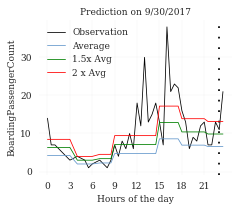

In [159]:
al_st=bo[bo["StopPointId"]==678]

col_y=["BoardingPassengerCount"]
da=30
mo=9
ho=23

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

al_st_inde=al_st.reset_index()
indexs=al_st_inde.index[(al_st_inde['TimeStep'].dt.month==mo) & (al_st_inde['TimeStep'].dt.day==da)] 

plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
H_min=al_st_inde.iloc[indexs].hours+(al_st_inde.iloc[indexs].TimeStep.dt.minute)/60


plt.plot(H_min,al_st_inde.BoardingPassengerCount.iloc[indexs],c="k", label="Observation",linewidth=0.8)
plt.plot(H_min,al_st_inde.Avg.iloc[indexs],c=colore, label="Average",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*1.5),c="g", label="1.5x Avg",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*2),c="r", label="2 x Avg",linewidth=0.8)

# plt.plot(H_min,y_test[0][indexs],c="k", label="True",linewidth=0.8)
# plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
# plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
# plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
# plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(loc=2)
plt.xticks(range(0,24,3))
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.title("Prediction on %s/%s/2017"%(mo,da))
plt.ylabel("%s"%(col_y[0]))
plt.xlabel("Hours of the day")


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/event_over_average_Vega_9_30_bo.pdf", format='pdf', bbox_inches='tight')

# over the avg dwell

In [109]:
col_y=["DwellSeconds"]
historical_average=[None] * len(dw)
historical_average=np.array(historical_average)

historical_average[(dw['day']==5)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)]=dw[col_y][(dw['day']==5)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)]=dw[col_y][(dw['day']==5)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)]=dw[col_y][(dw['day']==5)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)]=dw[col_y][(dw['day']==5)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)]=dw[col_y][(dw['day']==5)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)]=dw[col_y][(dw['day']==5)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)].mean()
#sunday
historical_average[(dw['day']==6)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)]=dw[col_y][(dw['day']==6)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)]=dw[col_y][(dw['day']==6)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)]=dw[col_y][(dw['day']==6)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)]=dw[col_y][(dw['day']==6)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)]=dw[col_y][(dw['day']==6)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)]=dw[col_y][(dw['day']==6)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)].mean()
#weekday
historical_average[(dw['day']<5)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)]=dw[col_y][(dw['day']<5)&(dw['hours']>=0)&(dw['isEvent']==0)&(dw['hours']<4)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)]=dw[col_y][(dw['day']<5)&(dw['hours']>=4)&(dw['isEvent']==0)&(dw['hours']<7)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)]=dw[col_y][(dw['day']<5)&(dw['hours']>=7)&(dw['isEvent']==0)&(dw['hours']<9)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)]=dw[col_y][(dw['day']<5)&(dw['hours']>=9)&(dw['isEvent']==0)&(dw['hours']<15)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)]=dw[col_y][(dw['day']<5)&(dw['hours']>=15)&(dw['isEvent']==0)&(dw['hours']<18)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)]=dw[col_y][(dw['day']<5)&(dw['hours']>=18)&(dw['isEvent']==0)&(dw['hours']<24)].mean()

#is event
historical_average[(dw['day']==5)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)]=dw[col_y][(dw['day']==5)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)]=dw[col_y][(dw['day']==5)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)]=dw[col_y][(dw['day']==5)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)]=dw[col_y][(dw['day']==5)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)]=dw[col_y][(dw['day']==5)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)].mean()
historical_average[(dw['day']==5)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)]=dw[col_y][(dw['day']==5)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)].mean()
#sunday
historical_average[(dw['day']==6)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)]=dw[col_y][(dw['day']==6)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)]=dw[col_y][(dw['day']==6)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)]=dw[col_y][(dw['day']==6)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)]=dw[col_y][(dw['day']==6)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)]=dw[col_y][(dw['day']==6)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)].mean()
historical_average[(dw['day']==6)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)]=dw[col_y][(dw['day']==6)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)].mean()
#weekday
historical_average[(dw['day']<5)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)]=dw[col_y][(dw['day']<5)&(dw['hours']>=0)&(dw['isEvent']>0)&(dw['hours']<4)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)]=dw[col_y][(dw['day']<5)&(dw['hours']>=4)&(dw['isEvent']>0)&(dw['hours']<7)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)]=dw[col_y][(dw['day']<5)&(dw['hours']>=7)&(dw['isEvent']>0)&(dw['hours']<9)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)]=dw[col_y][(dw['day']<5)&(dw['hours']>=9)&(dw['isEvent']>0)&(dw['hours']<15)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)]=dw[col_y][(dw['day']<5)&(dw['hours']>=15)&(dw['isEvent']>0)&(dw['hours']<18)].mean()
historical_average[(dw['day']<5)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)]=dw[col_y][(dw['day']<5)&(dw['hours']>=18)&(dw['isEvent']>0)&(dw['hours']<24)].mean()



In [114]:
dw['Avg']=historical_average
dw['real_minus_AVG']=dw['DwellSeconds']-dw['Avg']
dw['real_minus_AVG_rate']=dw['real_minus_AVG']/dw['Avg']


In [111]:
for st in dw.StopPointId.unique():
    print("\n",st)
    dw_st=dw[dw["StopPointId"]==st]
    print(len(dw_st[(dw_st['isEvent']>0)])/len(bo))
    print(len(dw_st[(dw_st['real_minus_AVG_rate']>0.5)&(dw_st['isEvent']>0)]),"\t",len(dw_st[(dw_st['real_minus_AVG_rate']>0.5)&(dw_st['isEvent']>0)])/len(dw_st[(dw_st['real_minus_AVG_rate']>0.5)]))
    print(len(dw_st[(dw_st['real_minus_AVG_rate']>1)&(dw_st['isEvent']>0)]),"\t",len(dw_st[(dw_st['real_minus_AVG_rate']>1)&(dw_st['isEvent']>0)])/len(dw_st[(dw_st['real_minus_AVG_rate']>1)]))


 1365
0.03857528192128953
227 	 0.11599386816555952
145 	 0.22003034901365706

 1586
0.254492866660167
1296 	 0.1043394251670558
341 	 0.08486809357889498

 678
0.09216470052971953
1609 	 0.05155729300179441
928 	 0.04757510509586794

 27999
0.17997465145754118
780 	 0.09818731117824774
380 	 0.1062342745317305

 860
0.09216470052971953
343 	 0.07414613056636403
95 	 0.06939371804236669


In [115]:
dw_st=dw[dw["StopPointId"]==1365]
dw_st[(dw_st['real_minus_AVG_rate']>0.5)&(dw_st['isEvent']>0)]

,Alternative&Punk_Music,Business,Children,Classic_Music,Culture,Design,Distance,DwellSeconds,DwellSeconds_lag1,DwellSeconds_lag2,DwellSeconds_lag3,DwellSeconds_lag4,DwellSeconds_lag5,Education,Electronica_Music,Entertainment,Football,Outdoor_Festival,Indipendent_Music,Lifestyle,Medicine,Metal_Music,Music,ObservedArrivalDateTime,PoiName,Pop_Music,Religious_Music,Rock_Music,Sport,StageMusicals_Music,StopPointId,Time_difference,Traditional_Music,Urban_Music,event_1h_aft,event_1h_bef,event_2h_aft,event_2h_bef,event_3h_aft,event_3h_bef,event_during,day,hours,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,isWeekend,Precipitation,Temperature,event_during_1h_aft,event_during_2h_aft,event_during_3h_aft,event_during_4h_aft,event_during_5h_aft,event_during_6h_aft,H0_4,H4_8,H8_12,H12_16,H16_20,H20_24,isStopping,isStopping_lag1,isStopping_lag2,isStopping_lag3,isStopping_lag4,isStopping_lag5,isEvent,Avg,real_minus_AVG,real_minus_AVG_rate
109377,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,31.0,0.0,17.0,0.0,23.0,23.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 11:37:56,Parken,0.0,0.0,0.0,0.0,0.0,1365,1.867778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1.0,16.0858,14.9142,0.927168
109437,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,80.0,31.0,0.0,17.0,0.0,23.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 12:09:37,Parken,0.0,0.0,0.0,0.0,0.0,1365,1.339722,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1.0,16.0858,63.9142,3.97334
109450,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,78.0,80.0,31.0,0.0,17.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 12:21:37,Parken,0.0,0.0,0.0,0.0,0.0,1365,1.139722,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1.0,16.0858,61.9142,3.849
109498,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,53.0,78.0,80.0,31.0,0.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 12:48:28,Parken,0.0,0.0,0.0,0.0,0.0,1365,0.692222,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,1.0,16.0858,36.9142,2.29484
109588,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,25.0,0.0,53.0,78.0,80.0,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 13:41:57,Parken,0.0,0.0,0.0,0.0,0.0,1365,-0.199167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.02,4.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1.0,16.0858,8.91422,0.554168
109924,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,27.0,14.0,16.0,15.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 17:00:42,Parken,0.0,0.0,0.0,0.0,0.0,1365,-3.511667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,2.0,17.4035,9.59649,0.551411
110080,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,38.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-19 18:41:10,Parken,0.0,0.0,0.0,0.0,0.0,1365,-5.186111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.02,4.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1.0,11.836,26.164,2.21053
119506,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,24.0,19.0,13.0,17.0,16.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-23 18:09:32,Parken,0.0,0.0,0.0,0.0,0.0,1365,2.924444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.10,3.0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1.0,14.3624,9.63759,0.671029
119643,0.0,0.0,0.0,0.0,0.0,0.0,108.368051,44.0,0.0,20.0,0.0,24.0,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-23 19:21:50,Parken,0.0,0.0,0.0,0.0,0.0,1365,1.719444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6.10,3.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1.0,14

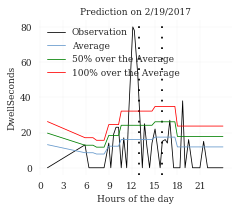

In [119]:
al_st=bo[bo["StopPointId"]==678]

col_y=["DwellSeconds"]
da=19
mo=2
ho=13
ho_1=16
plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))

al_st_inde=dw_st.reset_index()
indexs=al_st_inde.index[(al_st_inde['ObservedArrivalDateTime'].dt.month==mo) & (al_st_inde['ObservedArrivalDateTime'].dt.day==da)] 

plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
plt.axvline(ho_1,c="k",linestyle=(0, (1, 5)))
H_min=al_st_inde.iloc[indexs].hours+(al_st_inde.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60


plt.plot(H_min,al_st_inde.DwellSeconds.iloc[indexs],c="k", label="Observation",linewidth=0.8)
plt.plot(H_min,al_st_inde.Avg.iloc[indexs],c=colore, label="Average",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*1.5),c="g", label="50% over the Average",linewidth=0.8)
plt.plot(H_min,(al_st_inde.Avg.iloc[indexs]*2),c="r", label="100% over the Average",linewidth=0.8)

# plt.plot(H_min,y_test[0][indexs],c="k", label="True",linewidth=0.8)
# plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
# plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
# plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
# plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(loc=2)
plt.xticks(range(0,24,3))
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.title("Prediction on %s/%s/2017"%(mo,da))
plt.ylabel("%s"%(col_y[0]))
plt.xlabel("Hours of the day")


fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/event_over_average_Parken_2_19_dw.pdf", format='pdf', bbox_inches='tight')

# Topic distribution

In [10]:
names=["Alternative&Punk_Music","Business",	"Children",	"Classic_Music",	"Culture",	"Design",	"Education",	"Electronica_Music",	"Entertainment",	"Football",	"Outdoor Festival",	"Indipendent_Music",	"Lifestyle",	"Medicine",	"Metal_Music",	"Pop_Music",	"Religious_Music",	"Rock_Music",	"Sport",	"StageMusicals_Music",	"Traditional_Music",	"Urban_Music"]
val=[98,	8,	7,	115,	5,	3,	5,	29,	7,	35,	8,	5,	3,	7,	3,	22,	3,	55,	4,	3,	5,	37]
topic=pd.DataFrame([val],columns=names)
topicT=topic.T

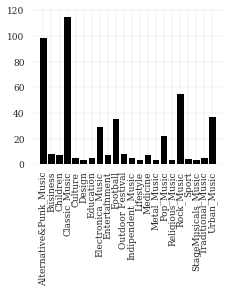

In [11]:

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
plt.xticks(range(22))
plt.xticks(rotation=90)
ax.bar(range(22),topicT[0],color="k")
ax.set_xticklabels(topicT.index.values)
plt.grid(b=True,c="grey",alpha=0.5,linewidth=0.2)

fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/event_topic_dist.pdf", format='pdf', bbox_inches='tight')

# day average

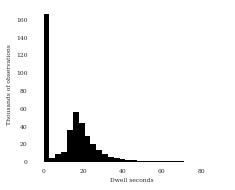

In [88]:
plt.rcParams.update(nice_fonts)


width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))

ax1.hist(dw.DwellSeconds,bins=30,color="k");
label=["0","20","40","60","80","100","120","140","160"]
ax1.set_yticklabels(["0","20","40","60","80","100","120","140","160"])
plt.ylabel("Thousands of observations")
plt.xlabel("Dwell seconds")
plt.show();

fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/dw_dist.pdf", format='pdf', bbox_inches='tight')

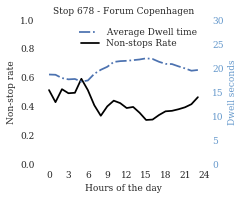

In [40]:
dw_no0=dw[dw['DwellSeconds']>0]
dw_not_stopped=dw[dw['DwellSeconds']==0]

dw_grouped=dw_no0.groupby(['hours'])['hours','DwellSeconds'].mean()
dw_grouped_not_stopped=dw_not_stopped.groupby(['hours'])['DwellSeconds', 'day'].count()
dw_grouped_all_stopped=dw.groupby(['hours'])['DwellSeconds', 'day'].count()

dw_grouped_not_stopped.reset_index(inplace=True)
dw_grouped_all_stopped.reset_index(inplace=True)

rate_of_stop_over_day=(dw_grouped_not_stopped.DwellSeconds/dw_grouped_all_stopped.DwellSeconds)

plt.rcParams.update(nice_fonts)


width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))


plt.title("Stop 678 - Forum Copenhagen")
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Non-stop rate')
ax1.plot(rate_of_stop_over_day, color="k",label="Non-stops Rate")
ax1.tick_params(axis='y',color="k")
ax1.grid(b=False)
plt.ylim([0,1])
plt.legend(loc=[0.22,0.78])#, fancybox=True, framealpha=0.5)
ax1.grid(b=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Dwell seconds',color=colore,)  # we already handled the x-label with ax1
ax2.plot(dw_grouped.DwellSeconds,linestyle=stile_linea,label=" Average Dwell time")
ax2.tick_params(axis='y',labelcolor=colore)
ax1.set_xticks(range(0,25,3))
ax2.grid(b=False)

plt.ylim([0,30])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)#, fancybox=True, framealpha=0.5)

plt.show()

# Save and remove excess whitespace
fig.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/dw_and_nonStop.pdf", format='pdf', bbox_inches='tight')

# event example

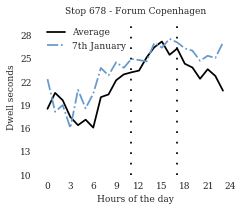

In [43]:
dw_F=dw[dw['PoiName']=="Forum"]
dw_F_1d=dw_F[dw_F['ObservedArrivalDateTime'].dt.month==1]
dw_F_1d=dw_F[dw_F['ObservedArrivalDateTime'].dt.day==7]
dw_F_1d_0=dw_F_1d[dw_F_1d['DwellSeconds']>0]
dw_F_1d_1=dw_F_1d[dw_F_1d['DwellSeconds']==0]
dw_F_1d_0_gr=dw_F_1d_0.groupby(['hours'])['DwellSeconds'].mean()
dw_F_1d_1_gr=dw_F_1d_1.groupby(['hours'])['DwellSeconds','day'].count()
dw_F_1d_gr=dw_F_1d.groupby(['hours'])['DwellSeconds','day'].count()
dw_J=dw_F[dw_F['ObservedArrivalDateTime'].dt.month==1]
dw_J=dw_J[dw_J['ObservedArrivalDateTime'].dt.day>4]
dw_J_0=dw_J[dw_J['DwellSeconds']>0]
dw_J_1=dw_J[dw_J['DwellSeconds']==0]

dw_J_0_gr=dw_J_0.groupby(['hours'])['DwellSeconds'].mean()
dw_J_1_gr=dw_J_1.groupby(['hours'])['DwellSeconds','day'].count()
dw_J_1_all_gr=dw_J.groupby(['hours'])['DwellSeconds','day'].count()

rate_of_st_J=dw_J_1_gr.DwellSeconds/dw_J_1_all_gr.DwellSeconds
rate_of_st=dw_F_1d_1_gr.DwellSeconds/dw_F_1d_gr.DwellSeconds

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'




fig, ax = plt.subplots(1, 1, figsize=set_size(width))



plt.plot(dw_J_0_gr, c="k",label="Average");
plt.plot(dw_F_1d_0_gr, linestyle='-.'  , c=colore,label="7th January");
plt.ylim([10,30])


ax.axvline(11,c="k",linestyle=(0, (1, 5)))
ax.axvline(17,c="k",linestyle=(0, (1, 5)))

ax.set_xticks(range(0,25,3))
ax.set_yticks(range(10,30,3))

ax.set_ylabel("Dwell seconds")
ax.set_xlabel("Hours of the day")
ax.legend(loc=2)


plt.title("Stop 678 - Forum Copenhagen")

# Save and remove excess whitespace
plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Dwell_sec_ev.pdf", format='pdf', bbox_inches='tight')

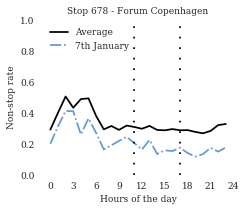

In [44]:

plt.rcParams.update(nice_fonts)

# Using seaborn's style
# plt.style.use('seaborn')
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'



# Initiboise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))


# Plot


# x_t=bo_678_1d.hours+(bo_678_1d.TimeStep.dt.minute)/60
# plt.plot(x_t,bo_678_1d.BoardingPassengerCount, c="k",label="20 January");
plt.plot(rate_of_st_J, c="k",label="Average");
plt.plot(rate_of_st, linestyle='-.'  , c=colore,label="7th January");
plt.ylim([0,1])


ax.axvline(11,c="k",linestyle=(0, (1, 5)))
ax.axvline(17,c="k",linestyle=(0, (1, 5)))

ax.set_xticks(range(0,25,3))

ax.set_ylabel("Non-stop rate")
ax.set_xlabel("Hours of the day")
ax.legend(loc=2)

plt.title("Stop 678 - Forum Copenhagen")


# Save and remove excess whitespace
plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Stops_ev.pdf", format='pdf', bbox_inches='tight')

# correlation

In [64]:
dw.StopPointId.unique()

array([ 1365,   715,  1586,   678,  1409, 28000, 27999,  7081,   900,
         860, 30941, 30942], dtype=int64)

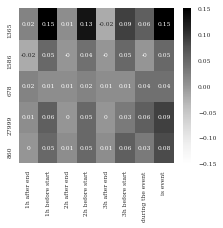

In [12]:
dw_for_corr=dw[[
    'DwellSeconds',
#        'DwellSeconds_lag1', 'DwellSeconds_lag2', 'DwellSeconds_lag3',
#        'DwellSeconds_lag4', 'DwellSeconds_lag5', 
    
#     'isStopping',
#        'isStopping_lag1', 'isStopping_lag2', 'isStopping_lag3',
#        'isStopping_lag4', 'isStopping_lag5',
#     'Education', 'Electronica_Music', 
#         'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music',
#        'Classical_Music', 'Culture', 'Design', 'Distance', 
#     'Entertainment', 'Football', 'Fælledparken',
#        'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',
#        'Music.1', 'ObservedArrivalDateTime',  'Pop_Music',
#        'Religious_Music', 'Rock_Music', 'Sport', 'StageMusicals_Music',
#        'Traditional_Music', 'Urban_Music',
#        'entertainment',
    'event_1h_aft', 'event_2h_aft','event_3h_aft',
        'event_1h_bef','event_2h_bef',  'event_3h_bef',
    'event_during',
#     'event_during_1h_aft',
#        'event_during_2h_aft', 'event_during_3h_aft', 'event_during_4h_aft',
#        'event_during_5h_aft', 'event_during_6h_aft', 
        'isEvent',
#     'H0_4', 'H4_8', 'H8_12',
#        'H12_16', 'H16_20', 'H20_24', 
#  'isWeekend',
#        'Precipitation', 'Temperature', 
]]

# dw_for_corr=dw_for_corr[dw_for_corr['DwellSeconds']>0]

round(dw_for_corr.corr(min_periods=1).dropna(axis=1, how='all').DwellSeconds.sort_values(ascending=False),2)



dw_corr_st=[]
for st in dw.StopPointId.unique():
    dw_for_corr_1=dw_for_corr[dw['StopPointId']==st]
    dw_corr_st.append(round(dw_for_corr_1.corr(min_periods=1).dropna(axis=1, how='all').DwellSeconds,2).sort_values(ascending=False))  
      

df = pd.DataFrame(dw_corr_st)
df.columns = ["dw" , "1h after end", "1h before start",  "2h after end", "2h before start", "3h after end", "3h before start","during the event","is event" ]

df = df.transpose()
df.columns = [dw.StopPointId.unique()]
df=df[1:]


nice_fonts = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 6,
        "font.size": 6,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
}





plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.heatmap(df.transpose(), annot=True,cmap="Greys" )


plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_dw.pdf", format='pdf', bbox_inches='tight')
    

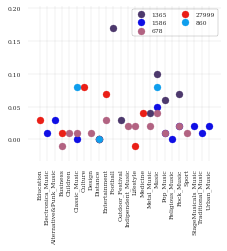

In [17]:
nice_fonts = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 6,
        "font.size": 6,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
}
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


dw_for_corr=dw[[
    'DwellSeconds',
#        'DwellSeconds_lag1', 'DwellSeconds_lag2', 'DwellSeconds_lag3',
#        'DwellSeconds_lag4', 'DwellSeconds_lag5', 
    
#     'isStopping',
#        'isStopping_lag1', 'isStopping_lag2', 'isStopping_lag3',
#        'isStopping_lag4', 'isStopping_lag5',
    'Education', 'Electronica_Music', 
        'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music',
        'Culture', 'Design', 'Distance', 
    'Entertainment', 'Football', 'Outdoor_Festival',
       'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',
         'Pop_Music',
       'Religious_Music', 'Rock_Music', 'Sport', 'StageMusicals_Music',
       'Traditional_Music', 'Urban_Music',
#     'event_1h_aft', 'event_2h_aft','event_3h_aft',
#         'event_1h_bef','event_2h_bef',  'event_3h_bef',
#     'event_during',
#     'event_during_1h_aft',
#        'event_during_2h_aft', 'event_during_3h_aft', 'event_during_4h_aft',
#        'event_during_5h_aft', 'event_during_6h_aft', 
#         'isEvent',
#     'H0_4', 'H4_8', 'H8_12',
#        'H12_16', 'H16_20', 'H20_24', 
#  'isWeekend',
#        'Precipitation', 'Temperature', 
]]

# dw_for_corr=dw_for_corr[dw_for_corr['DwellSeconds']>0]

round(dw_for_corr.corr(min_periods=1).dropna(axis=1, how='all').DwellSeconds.sort_values(ascending=False),2)



dw_corr_st=[]
for st in dw.StopPointId.unique():
    dw_for_corr_1=dw_for_corr[dw['StopPointId']==st]
    dw_corr_st.append(round(dw_for_corr_1.corr(min_periods=1).dropna(axis=1, how='all').DwellSeconds,2).sort_values(ascending=False))  
    

df = pd.DataFrame(dw_corr_st)
# df.columns = ["dw" , "1h after end", "1h before start",  "2h after end", "2h before start", "3h after end", "3h before start","during the event","is event" ]

df=df[[  'Education', 'Electronica_Music', 
        'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music',
        'Culture', 'Design', 'Distance', 
    'Entertainment', 'Football', 'Outdoor_Festival',
       'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',
         'Pop_Music',
       'Religious_Music', 'Rock_Music', 'Sport', 'StageMusicals_Music',
       'Traditional_Music', 'Urban_Music',
       ]]
df=df.rename(index=str, columns={"Fælledparken": "Outdoor festival"})
df = df.transpose()
df.columns = [dw.StopPointId.unique()]


plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))

i=0
for ine, row in df.transpose().iterrows():
    r1=random.uniform(0, 1)
    r2=random.uniform(0, 1)
    r3=random.uniform(0, 1)
    
    i+=1
    
    
    ax.scatter(range(24),row.values,label=ine,color=(color_scatter[i][0], color_scatter[i][1], color_scatter[i][2]))
    ax.set_xticklabels(df.index)
    plt.xticks(rotation=90)
    plt.xticks(range(24))
    plt.legend(ncol=2)
    plt.grid(b=True,c="grey",alpha=0.5,linewidth=0.2)
    legend = plt.legend(frameon = 1,loc=1,ncol=2)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    frame.set_alpha(0.5)

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_dw_topic.pdf", format='pdf', bbox_inches='tight')


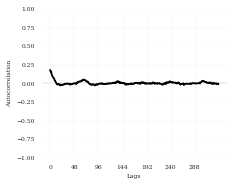

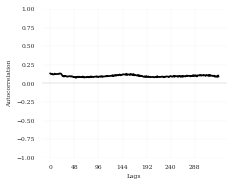

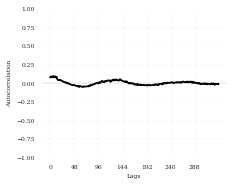

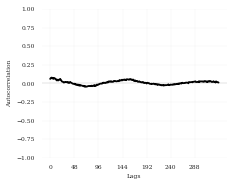

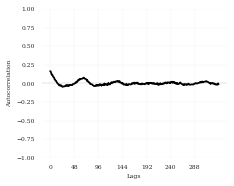

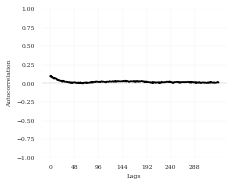

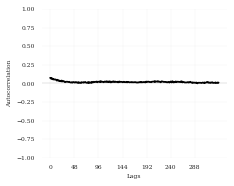

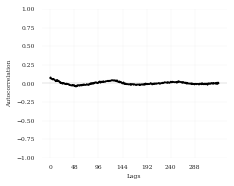

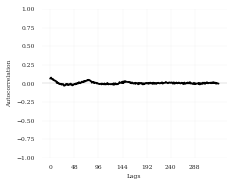

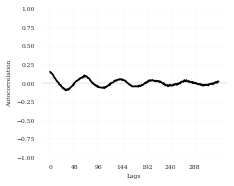

In [74]:
dw_lagged=dw
lista=[]
for st in dw_lagged.StopPointId.unique():
    df_1st=dw_lagged[dw_lagged['StopPointId']==st]
    df_1st_lagged=buildLaggedFeatures(df_1st,['DwellSeconds'])
    lista.append(df_1st_lagged)

# al_lagged=pd.concat(lista)
for el in lista:
    autocor_list=[]
    for i in range(336):
        i=i+1
        autocorr=el.DwellSeconds.corr(al_lagged["DwellSeconds_lag%s"%(i)])
        autocor_list.append(autocorr)


    plt.rcParams.update(nice_fonts)

    fig, ax = plt.subplots(1, 1, figsize=set_size(240))
    plt.rcParams.update(nice_fonts)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'


    plt.plot(autocor_list,c="k")
    plt.xticks(range(0,336,48))
    ax.xaxis.grid(False)
    plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
    plt.ylim([-1,1])
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lags")
    plt.axhline(0,c="k",alpha=0.3,linewidth=0.3)
    plt.show()

# plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Autocorr_dw.pdf", format='pdf', bbox_inches='tight')


---------

# distribution event

In [253]:
bo.describe()

print(bo.BoardingPassengerCount.quantile(0.98))
print(bo.BoardingPassengerCount.quantile(0.99))
print(al.AlightingPassengerCount.quantile(0.98))
print(al.AlightingPassengerCount.quantile(0.99))

21.0
25.0
18.0
22.0


In [254]:
dw['isEvent']= dw['event_1h_aft']+  dw['event_2h_aft']+ dw['event_3h_aft']+ dw['event_during']+ dw['event_1h_bef']+  dw['event_2h_bef']+ dw['event_3h_bef']
al['isEvent']=  al['event_1h_bef']+  al['event_2h_bef']+ al['event_3h_bef'] + al['event_during_1h_aft']+ al['event_during_2h_aft']
bo['isEvent']= bo['event_1h_aft']+  bo['event_2h_aft'] + bo['event_during_5h_aft']+ bo['event_during_6h_aft']

In [255]:
bo_ev=bo[bo['isEvent']>0]
bo_d=bo[bo['hours']>7]
print(len(bo_ev[bo_ev['BoardingPassengerCount']>=21])/len(bo_d[bo_d['BoardingPassengerCount']>21]))
print(len(bo_ev[bo_ev['BoardingPassengerCount']>=25])/len(bo_d[bo_d['BoardingPassengerCount']>25]))
print(len(bo_ev[bo_ev['BoardingPassengerCount']>0])/len(bo_d),"\n")

al_ev=al[al['isEvent']>0]
al_d=al[al['hours']>7]
print(len(al_ev[al_ev['AlightingPassengerCount']>=18])/len(al_d[al_d['AlightingPassengerCount']>21]))
print(len(al_ev[al_ev['AlightingPassengerCount']>=22])/len(al_d[al_d['AlightingPassengerCount']>25]))
print(len(al_ev[al_ev['AlightingPassengerCount']>0])/len(al_d))

0.05349048050770626
0.061068702290076333
0.02099891538201668 

0.19769874476987448
0.2553191489361702
0.08808855843778936


# correlation

In [18]:
al_for_corr=al[[
    'AlightingPassengerCount', 
#     'AlightingPassengerCount_lag1',
#        'AlightingPassengerCount_lag2', 'AlightingPassengerCount_lag3',
#        'AlightingPassengerCount_lag4', 'AlightingPassengerCount_lag5',
       'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music',
       'Culture', 'Design', 'Education',
       'Electronica_Music', 'Entertainment', 'Football', 'Outdoor_Festival',
       'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',
       'Pop_Music', 'Religious_Music', 'Rock_Music',
       'Sport', 'StageMusicals_Music',
       'Traditional_Music', 'Urban_Music', 
#        'event_1h_bef',  'event_2h_bef',
#        'event_3h_bef', 
#     'isWeekend', 'Precipitation', 'Temperature', 
#     'event_during_1h_aft', 'event_during_2h_aft',
#        'event_during_3h_aft', 'isEvent',
#     'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20',
#        'H20_24','Precipitation', 'Temperature'
]]

# round(al_for_corr.corr(min_periods=0).dropna(axis=1, how='all').AlightingPassengerCount,2).sort_values(ascending=False)


al_corr_st=[]
for st in al.StopPointId.unique():
    al_for_corr_1=al_for_corr[al['StopPointId']==st]
    al_corr_st.append(round(al_for_corr_1.corr(min_periods=0).dropna(axis=1, how='all').AlightingPassengerCount,2).sort_values(ascending=False))  
    
    
    

In [20]:
df = pd.DataFrame(al_corr_st)
# df.columns = ["al" , "1h before start","2h before start","3h before start","1h after start","2h after start","3h after start","is event" ]
df = df.transpose()
df.columns = [al.StopPointId.unique()]
df=df.iloc[1:]

In [21]:
color_scatter[0][1]


0.7319275357707336

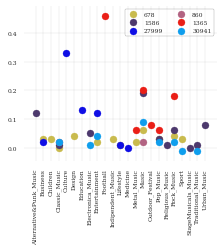

In [22]:

plt.rcParams.update(nice_fonts_small)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
i=0
# color_scatter=[]
for ine, row in df.transpose().iterrows():
#     r1=random.uniform(0, 1)
#     r2=random.uniform(0, 1)
#     r3=random.uniform(0, 1)
#     color_scatter.append([r1,r2,r3])
    
 
    ax.scatter(range(23),row.values,label=ine,color=(color_scatter[i][0], color_scatter[i][1], color_scatter[i][2]))
    i+=1
    ax.set_xticklabels(df.index)
    plt.xticks(rotation=90)
    plt.xticks(range(23))
    plt.grid(b=True,c="grey",alpha=0.5,linewidth=0.2)
    legend = plt.legend(frameon = 1,ncol=2,loc=1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    frame.set_alpha(0.5)
    

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_al_topic.pdf", format='pdf', bbox_inches='tight')


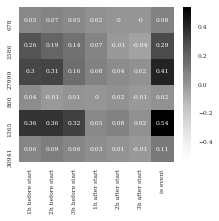

In [31]:
nice_fonts = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 6,
        "font.size": 6,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
}




plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.heatmap(df.transpose(), annot=True,cmap="Greys" )


plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_al.pdf", format='pdf', bbox_inches='tight')


In [23]:
bo_for_corr=bo[[
    'BoardingPassengerCount', 
#     'BoardingPassengerCount_lag1',
#        'BoardingPassengerCount_lag2', 'BoardingPassengerCount_lag3',
#        'BoardingPassengerCount_lag4', 'BoardingPassengerCount_lag5',
'Alternative&Punk_Music',  'Business',
       'Children', 'Classic_Music',  'Culture', 'Design',
       'Education', 'Electronica_Music', 'Entertainment', 'Football',
       'Outdoor_Festival', 'Indipendent_Music', 'Lifestyle', 'Medicine',
       'Metal_Music', 'Music', 'Pop_Music', 'Religious_Music', 'Rock_Music',
       'Sport', 'StageMusicals_Music', 'Traditional_Music', 'Urban_Music',


#        'event_1h_aft',  'event_2h_aft', 
#        'event_3h_aft',       'event_during_4h_aft', 'event_during_5h_aft',
#        'event_during_6h_aft', 'isEvent',
#     'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20','isWeekend', 
#        'H20_24','Precipitation', 'Temperature'
]]

bo_corr_st=[]
for st in bo.StopPointId.unique():
    bo_for_corr_1=bo_for_corr[bo['StopPointId']==st]
    bo_corr_st.append(round(bo_for_corr_1.corr(min_periods=0).dropna(axis=1, how='all').BoardingPassengerCount,2).sort_values(ascending=False))  
    
    
    

In [30]:
df = pd.DataFrame(bo_corr_st)
df=df[['Alternative&Punk_Music',  'Business',
       'Children', 'Classic_Music',  'Culture', 'Design',
       'Education', 'Electronica_Music', 'Entertainment', 'Football',
       'Outdoor_Festival', 'Indipendent_Music', 'Lifestyle', 'Medicine',
       'Metal_Music', 'Music', 'Pop_Music', 'Religious_Music', 'Rock_Music',
       'Sport', 'StageMusicals_Music', 'Traditional_Music', 'Urban_Music',
    ]]


# df.columns = ["pass",    "1h after end","2h after end","3h after end","4h after start","5h after start","6h after start","is event"]

df=df.rename(index=str, columns={"Fælledparken": "Outdoor festival"})
df = df.transpose()
df=df[1:]
df.columns = [bo.StopPointId.unique()]
df


,678,1586,1365,27999,860,30941
Business,0.03,NaN,NaN,0.00,NaN,NaN
Children,0.04,NaN,NaN,NaN,NaN,NaN
Classic_Music,0.01,0.00,NaN,NaN,0.01,-0.01
Culture,-0.01,NaN,NaN,0.28,NaN,NaN
Design,0.05,NaN,NaN,NaN,NaN,NaN
Education,NaN,NaN,NaN,0.04,NaN,NaN
Electronica_Music,NaN,-0.01,NaN,NaN,NaN,-0.01
Entertainment,0.03,NaN,NaN,0.15,NaN,-0.01
Football,NaN,NaN,0.10,NaN,NaN,NaN
Outdoor_Festival,NaN,NaN,-0.01,NaN,NaN,NaN


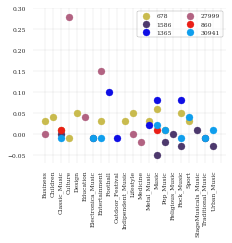

In [32]:

plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))

i=0
for ine, row in df.transpose().iterrows():
    r1=random.uniform(0, 1)
    r2=random.uniform(0, 1)
    r3=random.uniform(0, 1)
    ax.scatter(range(22),row.values,label=ine,color=(color_scatter[i][0], color_scatter[i][1], color_scatter[i][2]))
    i+=1
    ax.set_xticklabels(df.index)
    plt.xticks(rotation=90)
    plt.xticks(range(23))
    plt.legend(ncol=2)
    plt.grid(b=True,c="grey",alpha=0.5,linewidth=0.2)
    
    legend = plt.legend(frameon = 1,ncol=2,loc=1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    frame.set_alpha(0.5)
    
plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_bo_topic.pdf", format='pdf', bbox_inches='tight')


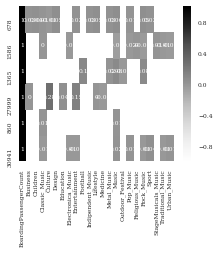

In [29]:
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.heatmap(df.transpose(), annot=True,cmap="Greys")


plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/heatmap_corr_st_bo.pdf", format='pdf', bbox_inches='tight')


# trend over day

In [90]:
dist_h_al=al.groupby(['hours'])['hours','AlightingPassengerCount'].mean()
dist_h_bo=bo.groupby(['hours'])['hours','BoardingPassengerCount'].mean()


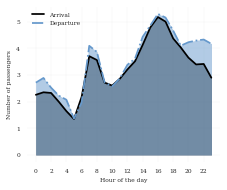

In [91]:
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.plot(dist_h_al.hours,dist_h_al.AlightingPassengerCount, color="k",label="Arrival")
plt.fill_between(dist_h_al.hours,dist_h_al.AlightingPassengerCount,alpha=0.5,color="k")

plt.plot(dist_h_bo.hours,dist_h_bo.BoardingPassengerCount, color=colore,linestyle='-.',label="Departure")
plt.fill_between(dist_h_bo.hours,dist_h_bo.BoardingPassengerCount,alpha=0.5,color=colore)

plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)

plt.xticks(range(0,24,2))

plt.ylabel("Number of passengers")
plt.xlabel("Hour of the day")
plt.legend(loc=0)




plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Daily_trend_passengers_demand.pdf", format='pdf', bbox_inches='tight')


# exammple event day

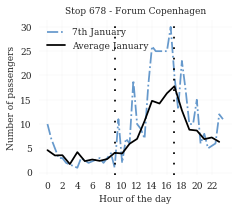

In [129]:
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

mo=1
da_e=7
bo_678=bo[bo['StopPointId']==678]
bo_678_j=bo_678[bo_678['TimeStep'].dt.month==mo]
bo_678_1d_ev=bo_678_j[bo_678_j['TimeStep'].dt.day==da_e]

bo_j=bo_678[bo_678['TimeStep'].dt.month==1]
bo_j=bo_j[bo_j['isWeekend']==1]
dist_h_bo=bo_j.groupby(['hours'])['hours','BoardingPassengerCount'].mean()

x_t2=bo_678_1d_ev.hours+(bo_678_1d_ev.TimeStep.dt.minute)/60
plt.plot(x_t2,bo_678_1d_ev.BoardingPassengerCount, c=colore,label="7th January",linestyle=stile_linea);

plt.plot(dist_h_bo.hours,dist_h_bo.BoardingPassengerCount, c="k",label="Average January");

plt.xticks(range(0,24,2))
plt.axvline(9,c="k",linestyle=(0, (1, 5)))
plt.axvline(17,c="k",linestyle=(0, (1, 5)))

plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)

plt.ylabel("Number of passengers")
plt.xlabel("Hour of the day")
plt.legend(loc=0)
plt.title("Stop 678 - Forum Copenhagen")

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Example_of_boarding_passengers_event_day.pdf", format='pdf', bbox_inches='tight')


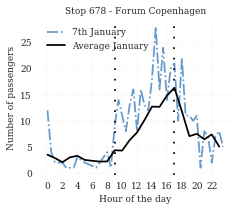

In [130]:
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


mo=1
da_e=7
bo_678=al[al['StopPointId']==678]
bo_678_j=bo_678[bo_678['TimeStep'].dt.month==mo]
bo_678_1d_ev=bo_678_j[bo_678_j['TimeStep'].dt.day==da_e]

bo_j=bo_678[bo_678['TimeStep'].dt.month==1]
bo_j=bo_j[bo_j['isWeekend']==1]
dist_h_bo=bo_j.groupby(['hours'])['hours','AlightingPassengerCount'].mean()

x_t2=bo_678_1d_ev.hours+(bo_678_1d_ev.TimeStep.dt.minute)/60
plt.plot(x_t2,bo_678_1d_ev.AlightingPassengerCount, c=colore,label="7th January",linestyle=stile_linea);

plt.plot(dist_h_bo.hours,dist_h_bo.AlightingPassengerCount, c="k",label="Average January");

plt.xticks(range(0,24,2))
plt.axvline(9,c="k",linestyle=(0, (1, 5)))
plt.axvline(17,c="k",linestyle=(0, (1, 5)))

plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)

plt.ylabel("Number of passengers")
plt.xlabel("Hour of the day")
plt.legend(loc=0)
plt.title("Stop 678 - Forum Copenhagen")

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Example_of_alighting_passengers_event_day.pdf", format='pdf', bbox_inches='tight')


# autocorrelationº

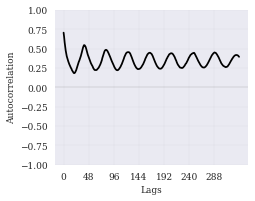

In [9]:
al_lagged=al[['AlightingPassengerCount',      'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music',  'Culture', 'Design', 'Distance', 'Education','Electronica_Music', 'Entertainment', 'Football',  'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',  'PoiName', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music', 'StopPointId', 'TimeStep','Time_difference', 'Traditional_Music', 'Urban_Music', 'event_1h_aft', 'event_1h_bef', 'event_2h_aft', 'event_2h_bef', 'event_3h_aft', 'event_3h_bef', 'event_during', 'day', 'hours', 'h_0','h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19','h_20', 'h_21', 'h_22', 'h_23', 'isWeekend', 'Precipitation','Temperature', 'event_during_1h_aft', 'event_during_2h_aft', 'event_during_3h_aft', 'event_during_4h_aft', 'event_during_5h_aft', 'event_during_6h_aft', 'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20','H20_24', 'isEvent']]
lista=[]
for st in al_lagged.StopPointId.unique():
    df_1st=al_lagged[al_lagged['StopPointId']==st]
    df_1st_lagged=buildLaggedFeatures(df_1st,['AlightingPassengerCount'])
    lista.append(df_1st_lagged)

al_lagged=pd.concat(lista)

autocor_list=[]
for i in range(336):
    i=i+1
    autocorr=al_lagged.AlightingPassengerCount.corr(al_lagged["AlightingPassengerCount_lag%s"%(i)])
    autocor_list.append(autocorr)
    
    
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


plt.plot(autocor_list,c="k")
plt.xticks(range(0,336,48))
ax.xaxis.grid(False)
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.ylim([-1,1])
plt.ylabel("Autocorrelation")
plt.xlabel("Lags")
plt.axhline(0,c="k",alpha=0.3,linewidth=0.3)

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Autocorr_al.pdf", format='pdf', bbox_inches='tight')


In [10]:
autocor_list

[0.70545279607236744,
 0.64997731599530484,
 0.58013970611790111,
 0.52583615797980887,
 0.47478492504556524,
 0.43498340165865362,
 0.40128709049718697,
 0.37736343030222824,
 0.35332663292701294,
 0.33330481087577696,
 0.31360800235413533,
 0.29585879777100371,
 0.28024548333696714,
 0.26658201952656618,
 0.25053363265997697,
 0.23932761141203651,
 0.22114585606276255,
 0.2101134007279048,
 0.1967619247958369,
 0.18847617225924704,
 0.18245152239730258,
 0.18493447525207213,
 0.19207271565494125,
 0.20525490425718712,
 0.22091019401992559,
 0.24282339428743552,
 0.26393211794806271,
 0.2872410653559333,
 0.30991241251282453,
 0.32978121791907133,
 0.34441745637082727,
 0.36402258582370428,
 0.38023987484370836,
 0.40585225663874369,
 0.43011886078721645,
 0.45749452891456721,
 0.48671588012025552,
 0.51121538321130533,
 0.53091340854833535,
 0.54443897075638348,
 0.54385549699827174,
 0.53441861865894502,
 0.52230667509455697,
 0.50172973400231036,
 0.47577574828303187,
 0.4501195963

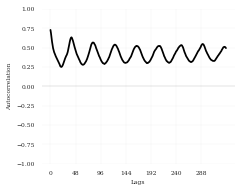

In [261]:
bo_lagged=bo[['BoardingPassengerCount',      'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music', 'Classical_Music', 'Culture', 'Design', 'Distance', 'Education','Electronica_Music', 'Entertainment', 'Football', 'Fælledparken', 'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Music',  'Music.1', 'PoiName', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music', 'StopPointId', 'TimeStep','Time_difference', 'Traditional_Music', 'Urban_Music', 'entertainment', 'event_1h_aft', 'event_1h_bef', 'event_2h_aft', 'event_2h_bef', 'event_3h_aft', 'event_3h_bef', 'event_during', 'day', 'hours', 'h_0','h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19','h_20', 'h_21', 'h_22', 'h_23', 'isWeekend', 'Precipitation','Temperature', 'event_during_1h_aft', 'event_during_2h_aft', 'event_during_3h_aft', 'event_during_4h_aft', 'event_during_5h_aft', 'event_during_6h_aft', 'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20','H20_24', 'isEvent']]
lista=[]
for st in bo_lagged.StopPointId.unique():
    df_1st=bo_lagged[bo_lagged['StopPointId']==st]
    df_1st_lagged=buildLaggedFeatures(df_1st,['BoardingPassengerCount'])
    lista.append(df_1st_lagged)

bo_lagged=pd.concat(lista)

autocor_list_bo=[]
for i in range(336):
    i=i+1
    autocorr=bo_lagged.BoardingPassengerCount.corr(bo_lagged["BoardingPassengerCount_lag%s"%(i)])
    autocor_list_bo.append(autocorr)
    
    
plt.rcParams.update(nice_fonts)

fig, ax = plt.subplots(1, 1, figsize=set_size(250))
plt.rcParams.update(nice_fonts)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


plt.plot(autocor_list_bo,c="k")
plt.xticks(range(0,336,48))
ax.xaxis.grid(False)
plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
plt.ylim([-1,1])
plt.ylabel("Autocorrelation")
plt.xlabel("Lags")
plt.axhline(0,c="k",alpha=0.3,linewidth=0.3)

plt.savefig("C:/Users/User/Desktop/DTU/Thesis/Figures/Autocorr_bo.pdf", format='pdf', bbox_inches='tight')
